### Configuration: number of files and ServiceX usage

In [1]:
# GLOBAL CONFIGURATION
N_FILES_MAX_PER_SAMPLE = 1  # input files per process, set to -1 for no limit / 1 or 10 for quick debugging  
USE_SERVICEX = False

### Processor

In [2]:
import time
import asyncio

import awkward as ak
from coffea import processor
from coffea.processor import servicex
import hist
import json
import numpy as np
import uproot
import cabinetry
from func_adl_servicex import ServiceXSourceUpROOT
from func_adl import ObjectStream
from servicex import ServiceXDataset
from coffea.nanoevents.schemas.base import BaseSchema


processor_base = processor.ProcessorABC if not USE_SERVICEX else servicex.Analysis

class TtbarAnalysis(processor_base):
    def __init__(self):
        num_bins = 23
        bin_low = 20
        bin_high = 250
        name = "mass"
        label = "m [GeV]"
        self.hist = (
            hist.Hist.new.Reg(num_bins, bin_low, bin_high, name=name, label=label)
            .StrCat([], name="process", label="Process", growth=True)
            .StrCat([], name="variation", label="Systematic variation", growth=True)
            .Weight()
        )

    def process(self, events):
        histogram = self.hist.copy()

        process = events.metadata["process"]  # "ttbar" etc.
        variation = events.metadata["variation"]  # "nominal" etc.
        
        # normalization for MC
        x_sec = events.metadata["xsec"]
        nevts_total = events.metadata["nevts"]
        lumi = 3378 # /pb
        if process != "data":
            xsec_weight = x_sec * lumi / nevts_total
        else:
            xsec_weight = 1
        
        
        # pT > 25 GeV for leptons & jets    
        selected_electrons = events.electron[events.electron.pt > 25]
        selected_muons = events.muon[events.muon.pt > 25]
        selected_jets = events.jet[events.jet.pt > 25]  # pT > 25 GeV for jets
        
        # single lepton requirement
        event_filters = (ak.count(selected_electrons.pt, axis=1) & ak.count(selected_muons.pt, axis=1) == 1)
        # at least four jets
        event_filters = event_filters & (ak.count(selected_jets.pt, axis=1) >= 4)
        # at least two b-tagged jets ("tag" means > 0.15 score here)
        event_filters = event_filters & (ak.sum(selected_jets.btag > 0.15, axis=1) > 2)
        
        # apply filters
        selected_events = events[event_filters]

        histogram.fill(
            mass=ak.sum(selected_events.jet, axis=-1).mass, process=process, variation=variation, weight=xsec_weight
        )

        output = {"nevents": {events.metadata["dataset"]: len(events)}, "hist": histogram}

        return output

    def postprocess(self, accumulator):
        return accumulator

### AGC schema (for pure coffea)

In [3]:
from coffea.nanoevents.schemas.base import BaseSchema, zip_forms
from coffea.nanoevents.methods import base, vector
from coffea.nanoevents import transforms


# https://github.com/mat-adamec/agc_coffea/blob/main/agc_schema.py
class AGCSchema(BaseSchema):
    def __init__(self, base_form):
        super().__init__(base_form)
        self._form["contents"] = self._build_collections(self._form["contents"])

    def _build_collections(self, branch_forms):
        names = set([k.split('_')[0] for k in branch_forms.keys() if not (k.startswith('number'))])
        # Remove n(names) from consideration. It's safe to just remove names that start with n, as nothing else begins with n in our fields.
        # Also remove GenPart, PV and MET because they deviate from the pattern of having a 'number' field.
        names = [k for k in names if not (k.startswith('n') | k.startswith('met') | k.startswith('GenPart') | k.startswith('PV'))]
        output = {}
        for name in names:
            offsets = transforms.counts2offsets_form(branch_forms['number' + name])
            content = {k[len(name)+1:]: branch_forms[k] for k in branch_forms if (k.startswith(name + "_") & (k[len(name)+1:] != 'e'))}
            # Add energy separately so its treated correctly by the p4 vector.
            content['energy'] = branch_forms[name+'_e']
            # Check for LorentzVector
            output[name] = zip_forms(content, name, 'PtEtaPhiELorentzVector', offsets=offsets)

        # Handle GenPart, PV, MET. Note that all the nPV_*'s should be the same. We just use one.
        output['met'] = zip_forms({k[len('met')+1:]: branch_forms[k] for k in branch_forms if k.startswith('met_')}, 'met')
        #output['GenPart'] = zip_forms({k[len('GenPart')+1:]: branch_forms[k] for k in branch_forms if k.startswith('GenPart_')}, 'GenPart', offsets=transforms.counts2offsets_form(branch_forms['numGenPart']))
        output['PV'] = zip_forms({k[len('PV')+1:]: branch_forms[k] for k in branch_forms if (k.startswith('PV_') & ('npvs' not in k))}, 'PV', offsets=transforms.counts2offsets_form(branch_forms['nPV_x']))
        return output

    @property
    def behavior(self):
        behavior = {}
        behavior.update(base.behavior)
        behavior.update(vector.behavior)
        return behavior

### metadata & fileset construction

In [4]:
# using https://atlas-groupdata.web.cern.ch/atlas-groupdata/dev/AnalysisTop/TopDataPreparation/XSection-MC15-13TeV.data
# x-secs are in pb
xsec_info = {
    "ttbar": 396.87 + 332.97, # nonallhad + allhad, keep same x-sec for all
    "single_top_s_chan": 2.0268 + 1.2676,
    "single_top_t_chan": (36.993 + 22.175)/0.252,  # scale from lepton filter to inclusive
    "single_top_tW": 37.936 + 37.906,
    "wjets": 61457 * 0.252,  # e/mu+nu final states
    "data": None
}

# list of files
with open("ntuples.json") as f:
    file_info = json.load(f)

# process into "fileset" summarizing all info
fileset = {}
for process in file_info.keys():
    if process == "data":
        continue  # skip data

    for variation in file_info[process].keys():
        file_list = file_info[process][variation]["files"]
        if N_FILES_MAX_PER_SAMPLE != -1:
            file_list = file_list[:N_FILES_MAX_PER_SAMPLE]  # use partial set of samples

        file_paths = [f["path"] for f in file_list]
        nevts_total = sum([f["nevts"] for f in file_list])
        metadata = {"process": process, "variation": variation, "nevts": nevts_total, "xsec": xsec_info[process]}
        fileset.update({f"{process}__{variation}": {"files": file_paths, "metadata": metadata}})

### ServiceX-specific functionality: datasource construction, query, asyncio

In [5]:
def make_datasource(fileset:dict, name: str, query: ObjectStream, ignore_cache: bool):
    """Creates a ServiceX datasource for a particular ATLAS Open data file."""
    datasets = [ServiceXDataset(fileset[name]["files"], backend_name="uproot", ignore_cache=ignore_cache)]
    return servicex.DataSource(
        query=query, metadata=fileset[name]["metadata"], datasets=datasets
    )

def get_query(source: ObjectStream) -> ObjectStream:
    """Performs event selection: no filter, select all columns
    """
    #return source.Select(lambda e: {"electron_pt": e.el_pt, "electron_eta": e.el_eta, "electron_phi": e.el_phi})
    return source.Select(lambda e: {
                                    "electron_e": e.electron_e,
                                    "electron_pt": e.electron_pt,
                                    "electron_px": e.electron_px,
                                    "electron_py": e.electron_py,
                                    "electron_pz": e.electron_pz,
                                    "electron_eta": e.electron_eta,
                                    "electron_phi": e.electron_phi,
                                    "electron_ch": e.electron_ch,
                                    "electron_iso": e.electron_iso,
                                    "electron_isLoose": e.electron_isLoose,
                                    "electron_isMedium": e.electron_isMedium,
                                    "electron_isTight": e.electron_isTight,
                                    "electron_dxy": e.electron_dxy,
                                    "electron_dz": e.electron_dz,
                                    "electron_dxyError": e.electron_dxyError,
                                    "electron_dzError": e.electron_dzError,

                                    "numbermuon": e.numbermuon,
                                    "muon_e": e.muon_e,
                                    "muon_pt": e.muon_pt,
                                    "muon_px": e.muon_px,
                                    "muon_py": e.muon_py,
                                    "muon_pz": e.muon_pz,
                                    "muon_eta": e.muon_eta,
                                    "muon_phi": e.muon_phi,
                                    "muon_ch": e.muon_ch,
                                    "muon_isSoft": e.muon_isSoft,
                                    "muon_isTight": e.muon_isTight,
                                    "muon_dxy": e.muon_dxy,
                                    "muon_dz": e.muon_dz,
                                    "muon_dxyError": e.muon_dxyError,
                                    "muon_dzError": e.muon_dzError,
                                    "muon_pfreliso03all": e.muon_pfreliso03all,
                                    "muon_pfreliso04all": e.muon_pfreliso04all,
                                    "muon_jetidx": e.muon_jetidx,
                                    "muon_genpartidx": e.muon_genpartidx,

                                    "jet_e": e.jet_e,
                                    "jet_pt": e.jet_pt,
                                    "jet_px": e.jet_px,
                                    "jet_py": e.jet_py,
                                    "jet_pz": e.jet_pz,
                                    "jet_eta": e.jet_eta,
                                    "jet_phi": e.jet_phi,
                                    "jet_ch": e.jet_ch,
                                    "jet_mass": e.jet_mass,
                                    "jet_btag": e.jet_btag,
                                    "jet_pt_uncorr": e.jet_pt_uncorr,
                                   }
)


async def produce_all_histograms(fileset):
    """Runs the histogram production, processing input files with ServiceX and
    producing histograms with coffea.
    """
    # create the query
    ds = ServiceXSourceUpROOT("cernopendata://dummy", "events", backend_name="uproot")
    ds.return_qastle = True
    data_query = get_query(ds)

    # EXECUTOR: local vs Dask
    executor = servicex.LocalExecutor()
    #executor = servicex.DaskExecutor(client_addr="tls://localhost:8786")

    datasources = [
        make_datasource(fileset, ds_name, data_query, ignore_cache=False)  # CACHING
        for ds_name in fileset.keys()
    ]

    # create the analysis processor
    analysis_processor = TtbarAnalysis()

    async def run_updates_stream(accumulator_stream, name):
        """Run to get the last item in the stream"""
        coffea_info = None
        try:
            async for coffea_info in accumulator_stream:
                pass
        except Exception as e:
            raise Exception(f"Failure while processing {name}") from e
        return coffea_info

    all_histogram_dicts = await asyncio.gather(
        *[
            run_updates_stream(
                executor.execute(analysis_processor, source),
                f"{source.metadata['process']}__{source.metadata['variation']}",
            )
            for source in datasources
        ]
    )
    all_histograms = sum([h["hist"] for h in all_histogram_dicts])
    
    return all_histograms

### execute

In [6]:
if USE_SERVICEX:
    t0 = time.time()

    # in a notebook:
    all_histograms = await produce_all_histograms(fileset)

    # as a script:
    # async def produce_all_the_histograms(fileset):
    #    return await produce_all_histograms(fileset)
    #
    # all_histograms = asyncio.run(produce_all_the_histograms(fileset))
    
    print(f"execution took {time.time() - t0:.2f} seconds")

else:
    USE_DASK = False

    if USE_DASK:
        from dask.distributed import Client

        client = Client("tls://localhost:8786")
        executor = processor.DaskExecutor(client=client)
    else:
        executor = processor.IterativeExecutor()

    run = processor.Runner(executor=executor, schema=AGCSchema, savemetrics=True, metadata_cache={})

    all_histograms, metrics = run(fileset, "events", processor_instance=TtbarAnalysis())
    all_histograms = all_histograms["hist"]

Output()

Output()

### plotting 

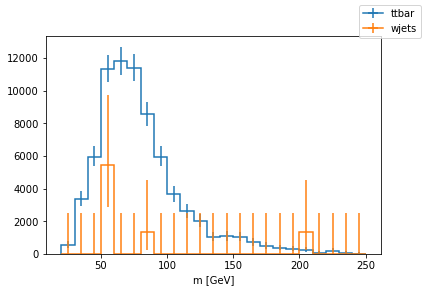

In [7]:
all_histograms[:, "ttbar", "nominal"].plot(stack=True, label="ttbar")
all_histograms[:, "wjets", "nominal"].plot(stack=True, label="wjets")
# all_histograms[:, "single_top_s_chan", "nominal"].plot(stack=True, label="s-chan")
# all_histograms[:, "single_top_t_chan", "nominal"].plot(stack=True, label="t-chan")
# all_histograms[:, "single_top_tW", "nominal"].plot(stack=True, label="tW")

#all_histograms[:, "data", "nominal"].plot(label="data")


import matplotlib.pyplot as plt
fig = plt.gcf()
fig.legend()
#fig.axes[0].set_yscale("log")

#print("data", sum(all_histograms["hist"][:, "data", "nominal"].values()/1e6), "M")
#print("ttbar", sum(all_histograms["hist"][:, "ttbar", "nominal"].values()/1e6), "M")

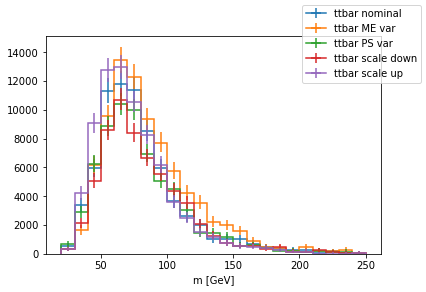

In [8]:
all_histograms[:, "ttbar", "nominal"].plot(label="ttbar nominal")
all_histograms[:, "ttbar", "ME_var"].plot(label="ttbar ME var")
all_histograms[:, "ttbar", "PS_var"].plot(label="ttbar PS var")
all_histograms[:, "ttbar", "scaledown"].plot(label="ttbar scale down")
all_histograms[:, "ttbar", "scaleup"].plot(label="ttbar scale up")

fig = plt.gcf()
fig.legend()

### saving histograms & cabinetry

In [9]:
file_name = "histograms.root"
with uproot.recreate(file_name) as f:
    f["ttbar"] = all_histograms[:, "ttbar", "nominal"]
    f["ttbar_ME_var"] = all_histograms[:, "ttbar", "ME_var"]
    f["ttbar_PS_var"] = all_histograms[:, "ttbar", "PS_var"]
    f["ttbar_scaledown"] = all_histograms[:, "ttbar", "scaledown"]
    f["ttbar_scaleup"] = all_histograms[:, "ttbar", "scaleup"]
    
    f["wjets"] = all_histograms[:, "wjets", "nominal"]
    f["single_top_s_chan"] = all_histograms[:, "single_top_s_chan", "nominal"]
    f["single_top_t_chan"] = all_histograms[:, "single_top_t_chan", "nominal"]
    f["single_top_tW"] = all_histograms[:, "single_top_tW", "nominal"]

Signal_region_Data has empty bins: [22]
Signal_region_ttbar has empty bins: [22]
Signal_region_ttbar_PS-variation_Up has empty bins: [22]
Signal_region_ttbar_scale-variation_Up has empty bins: [19 20 21]
Signal_region_W+jets has empty bins: [ 0  1  2  4  5  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22]
Signal_region_single-top,-s-channel has empty bins: [14 16 17 19 20 21 22]
Signal_region_single-top,-t-channel has empty bins: [14 16 17 19 20 21 22]
Signal_region_tW has empty bins: [18]
Signal_region_Data has empty bins: [22]
Signal_region_ttbar has empty bins: [22]
Signal_region_ttbar_PS-variation_Up has empty bins: [22]
Signal_region_ttbar_scale-variation_Up has empty bins: [19 20 21]
Signal_region_W+jets has empty bins: [ 0  1  2  4  5  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22]
Signal_region_single-top,-s-channel has empty bins: [14 16 17 19 20 21 22]
Signal_region_single-top,-t-channel has empty bins: [14 16 17 19 20 21 22]
Signal_region_tW has empty bins: [18]


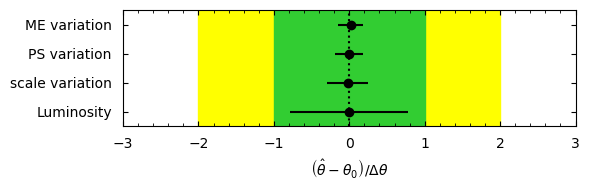

In [10]:
config = cabinetry.configuration.load("config.yml")
cabinetry.templates.collect(config)
cabinetry.templates.postprocess(config)  # optional post-processing (e.g. smoothing)
ws = cabinetry.workspace.build(config)

model, data = cabinetry.model_utils.model_and_data(ws)
fit_results = cabinetry.fit.fit(model, data)

cabinetry.visualize.pulls(
    fit_results, exclude="ttbar_norm", close_figure=True, save_figure=False
)


In [13]:
if not USE_SERVICEX:
    print(f"number of files processed: {metrics['chunks']}")
    print(f"data read: {metrics['bytesread']/1024**2:.1f} MB")

    metrics

number of files processed: 9
data read: 1.2 MB
